In [1]:
from tensorflow.keras.preprocessing.image import load_img
from keras.applications.imagenet_utils import preprocess_input
# First, we'll import pandas and numpy, two data processing libraries
import pandas as pd
import numpy as np

# We'll also import seaborn and matplot, twp Python graphing libraries
import seaborn as sns
import matplotlib.pyplot as plt
# Import the needed sklearn libraries
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

# The Keras library provides support for neural networks and deep learning
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout2D, Activation, Lambda, Flatten, LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
#from tensorflow.keras.utils import np_utils
from tensorflow.keras import utils

In [2]:
# Load on image from folder
train_folder = '/Users/jenny/MLGroupProjectData/MLGroupProjectData/train'
test_folder = '/Users/jenny/MLGroupProjectData/MLGroupProjectData/test'
validate_folder = '/Users/jenny/MLGroupProjectData/MLGroupProjectData/valid'

normal_folder = '/normal'
adenocarcinoma_folder = '/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib'
large_cell_carcinoma_folder = '/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa'
squamous_cell_carcinoma_folder = '/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa'

In [3]:
from glob import glob
from PIL import Image

def plot_images(imgs, rows=5):
    # Set figure to 15 inches x 8 inches
    figure = plt.figure(figsize=(25, 12))
    cols = len(imgs) // rows + 1
    for i in range(len(imgs)):
        subplot = figure.add_subplot(rows, cols, i + 1)
        subplot.axis('Off')
        plt.imshow(imgs[i])

def plot_images_for_filenames(filenames, rows=5):
    imgs = [plt.imread(f'{filename}') for filename in filenames]
    return plot_images(imgs, rows)

['/Users/jenny/MLGroupProjectData/MLGroupProjectData/train/normal/17.png']
Images of Normal lungs


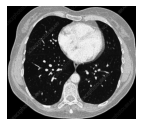

In [4]:
sample17_images = glob(train_folder + normal_folder + '/17.png')
print (sample17_images)
print ("Images of Normal lungs")
plot_images_for_filenames(sample17_images) 

### Set up callbacks for training

#### learning_rate_reduction: This reduces the Learning Rate during training.
#### early_stops: EarlyStopping stops the training if the model is not learning is not improving.
#### checkpointer: ModelCheckpoint saves best weights of the model.

In [5]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

learning_rate_reduction = ReduceLROnPlateau(monitor='loss', 
                                            patience=5, 
                                            verbose=2, 
                                            factor=0.5,                                            
                                            min_lr=0.000001)

early_stops = EarlyStopping(monitor='loss', 
                            min_delta=0, 
                            patience=6, 
                            verbose=2, 
                            mode='auto')

checkpointer = ModelCheckpoint(filepath = 'cis3115.{epoch:02d}-{accuracy:.6f}.hdf5',
                               verbose=2,
                               save_best_only=True, 
                               save_weights_only = True)

In [6]:
# Read data from the folders

IMAGE_SIZE = (224, 224)

print ("Reading training images from: " ,train_folder)
print ("Reading validation images from: " ,validate_folder)

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
#        rotation_range=10,
#        width_shift_range=0.1,
#        height_shift_range=0.1,
        rescale=1./255,
#        shear_range=0.1,
#        zoom_range=0.1,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 8
#batch_size = 32              # This performs better but might take too much memory

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
print ("===== Setting up training image generator")
train_generator = train_datagen.flow_from_directory(
        train_folder,  # this is the target directory
        target_size=IMAGE_SIZE,  # all images will be resized to 150x150
        batch_size=batch_size,
        color_mode="rgb", 
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
print ("===== Setting up test image generator")
validation_generator = test_datagen.flow_from_directory(
        test_folder,
        target_size=IMAGE_SIZE,
        batch_size=batch_size,
        color_mode="rgb", 
        class_mode='categorical')

# We will display the loss and the accuracy of the model for each epoch
# NOTE: this is a little fancier display than is shown in the textbook
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

Reading training images from:  /Users/jenny/MLGroupProjectData/MLGroupProjectData/train
Reading validation images from:  /Users/jenny/MLGroupProjectData/MLGroupProjectData/valid
===== Setting up training image generator
Found 613 images belonging to 4 classes.
===== Setting up test image generator
Found 315 images belonging to 4 classes.


In [12]:
# Set up the Neural Network

# Number of catagories of images
OUTPUT_SIZE = 4
# ==== Select one of the pre-trained models from Keras.  Samples are shown below
#pretrained_model = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.EfficientNetB4(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
pretrained_model = tf.keras.applications.Xception(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])

# Set the following to False so that the pre-trained weights are not changed 
pretrained_model.trainable = False 

model = Sequential()
#  Start with the pretrained model defined above
model.add(pretrained_model)

# Flatten 2D images into 1D data for final layers like traditional neural network
model.add(GlobalAveragePooling2D())
model.add(Dense(OUTPUT_SIZE, activation='softmax'))

print ("Pretrained model used:")
pretrained_model.summary()

#  ========== Uncomment the following code to define your own CNN ============
#model = Sequential()
#  Apply convolution filters and then reduce image size using MaxPooling
#model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', input_shape=[*IMAGE_SIZE, 3]))
#model.add(Conv2D(8, (3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#  Apply convolution filters and then reduce image size using MaxPooling
#model.add(Conv2D(16, (3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#  Apply convolution filters and then reduce image size using MaxPooling
#model.add(Conv2D(32, (3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#  Apply convolution filters and then reduce image size using MaxPooling
#model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
# Flatten 2D images into 1D data for final layers like traditional neural network
#model.add(Flatten())
#model.add(Dense(256, activation='relu'))
#model.add(Dense(OUTPUT_SIZE, activation='softmax'))

print ("Final model created:")
model.summary()

# Compile neural network model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Pretrained model used:
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                   

In [8]:
# Train the model with the images in the folders
history = model.fit(
        train_generator,
        steps_per_epoch=25,                     # Number of images to process per epoch 
        epochs=50,                              # Number of epochs
        callbacks=[learning_rate_reduction, early_stops],
        validation_data=validation_generator,
        validation_steps=20                     # Number of images from validation set to test
        )

print ("Final training accuracy = ",history.history['accuracy'][-1])
print ("Final testing accuracy = ",history.history['val_accuracy'][-1])

Epoch 1/50
25/25 [==============================] - 94s 3s/step - loss: 1.2840 - accuracy: 0.4010 - val_loss: 1.0555 - val_accuracy: 0.5375 - lr: 0.0010
Epoch 2/50
25/25 [==============================] - 75s 3s/step - loss: 1.0282 - accuracy: 0.5000 - val_loss: 1.1339 - val_accuracy: 0.3875 - lr: 0.0010
Epoch 3/50
25/25 [==============================] - 73s 3s/step - loss: 0.8635 - accuracy: 0.6345 - val_loss: 0.8943 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 4/50
25/25 [==============================] - 71s 3s/step - loss: 0.7587 - accuracy: 0.6650 - val_loss: 0.8412 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/50
25/25 [==============================] - 71s 3s/step - loss: 0.7676 - accuracy: 0.6650 - val_loss: 0.9237 - val_accuracy: 0.5813 - lr: 0.0010
Epoch 6/50
25/25 [==============================] - 73s 3s/step - loss: 0.6990 - accuracy: 0.7100 - val_loss: 0.8721 - val_accuracy: 0.6375 - lr: 0.0010
Epoch 7/50
25/25 [==============================] - 74s 3s/step - loss: 0.6787 - a

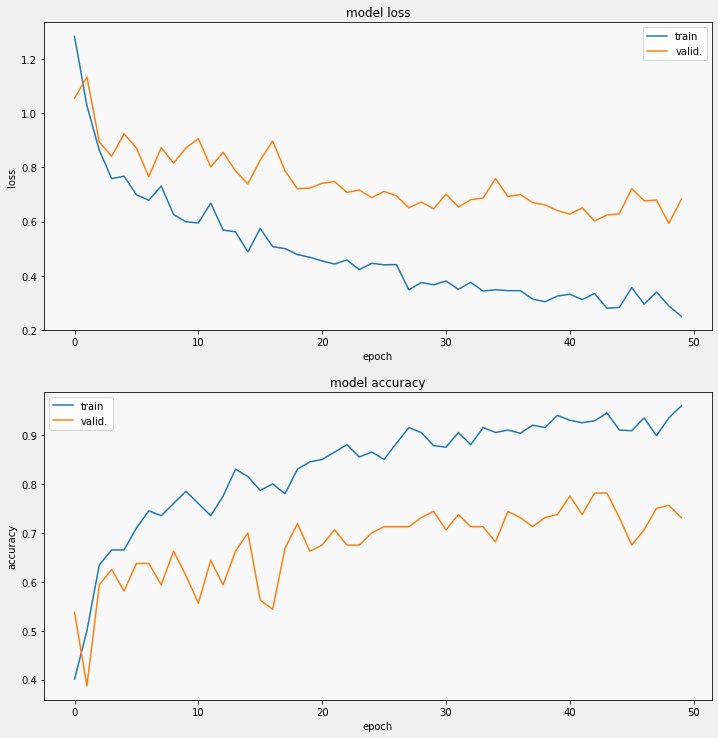

In [9]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 212)

In [10]:
# Set up the Neural Network

# Number of catagories of images
OUTPUT_SIZE = 4
# ==== Select one of the pre-trained models from Keras.  Samples are shown below
#pretrained_model = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.EfficientNetB4(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.Xception(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])

# Set the following to False so that the pre-trained weights are not changed 
pretrained_model.trainable = False 

model = Sequential()
#  Start with the pretrained model defined above
model.add(pretrained_model)

# Flatten 2D images into 1D data for final layers like traditional neural network
model.add(GlobalAveragePooling2D())
model.add(Dense(OUTPUT_SIZE, activation='softmax'))

print ("Pretrained model used:")
pretrained_model.summary()

#  ========== Uncomment the following code to define your own CNN ============
#model = Sequential()
#  Apply convolution filters and then reduce image size using MaxPooling
#model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', input_shape=[*IMAGE_SIZE, 3]))
#model.add(Conv2D(8, (3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#  Apply convolution filters and then reduce image size using MaxPooling
#model.add(Conv2D(16, (3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#  Apply convolution filters and then reduce image size using MaxPooling
#model.add(Conv2D(32, (3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#  Apply convolution filters and then reduce image size using MaxPooling
#model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
# Flatten 2D images into 1D data for final layers like traditional neural network
#model.add(Flatten())
#model.add(Dense(256, activation='relu'))
#model.add(Dense(OUTPUT_SIZE, activation='softmax'))

print ("Final model created:")
model.summary()

# Compile neural network model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Pretrained model used:
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56

In [11]:
# Train the model with the images in the folders
history = model.fit(
        train_generator,
        steps_per_epoch=25,                     # Number of images to process per epoch 
        epochs=50,                              # Number of epochs
        callbacks=[learning_rate_reduction, early_stops],
        validation_data=validation_generator,
        validation_steps=20                     # Number of images from validation set to test
        )

print ("Final training accuracy = ",history.history['accuracy'][-1])
print ("Final testing accuracy = ",history.history['val_accuracy'][-1])

Epoch 1/50
25/25 [==============================] - 107s 4s/step - loss: 1.3530 - accuracy: 0.3700 - val_loss: 1.2976 - val_accuracy: 0.4250 - lr: 0.0010
Epoch 2/50
25/25 [==============================] - 105s 4s/step - loss: 1.3126 - accuracy: 0.4200 - val_loss: 1.2640 - val_accuracy: 0.5188 - lr: 0.0010
Epoch 3/50
25/25 [==============================] - 102s 4s/step - loss: 1.2376 - accuracy: 0.5500 - val_loss: 1.2447 - val_accuracy: 0.4750 - lr: 0.0010
Epoch 4/50
25/25 [==============================] - 103s 4s/step - loss: 1.1731 - accuracy: 0.5800 - val_loss: 1.1904 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/50
25/25 [==============================] - 105s 4s/step - loss: 1.1799 - accuracy: 0.4700 - val_loss: 1.2232 - val_accuracy: 0.5063 - lr: 0.0010
Epoch 6/50
25/25 [==============================] - 118s 5s/step - loss: 1.1390 - accuracy: 0.4850 - val_loss: 1.1868 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 7/50
25/25 [==============================] - 103s 4s/step - loss: 1.0

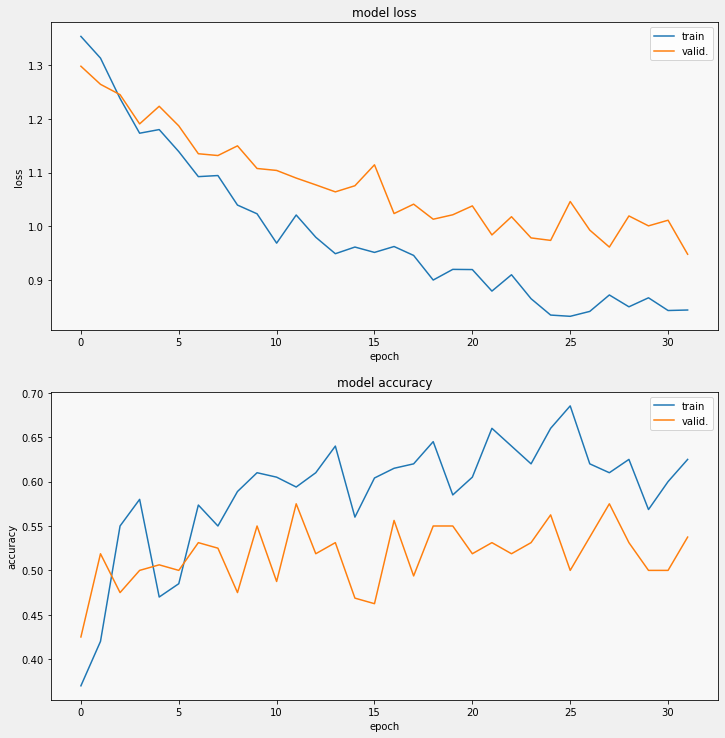

In [13]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 212)

In [14]:
# Set up the Neural Network

# Number of catagories of images
OUTPUT_SIZE = 4
# ==== Select one of the pre-trained models from Keras.  Samples are shown below
#pretrained_model = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.EfficientNetB4(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.Xception(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])

# Set the following to False so that the pre-trained weights are not changed 
#pretrained_model.trainable = False 

#model = Sequential()
#  Start with the pretrained model defined above
#model.add(pretrained_model)

# Flatten 2D images into 1D data for final layers like traditional neural network
#model.add(GlobalAveragePooling2D())
#model.add(Dense(OUTPUT_SIZE, activation='softmax'))

#print ("Pretrained model used:")
#pretrained_model.summary()

#  ========== Uncomment the following code to define your own CNN ============
model = Sequential()
#  Apply convolution filters and then reduce image size using MaxPooling
model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', input_shape=[*IMAGE_SIZE, 3]))
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#  Apply convolution filters and then reduce image size using MaxPooling
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#  Apply convolution filters and then reduce image size using MaxPooling
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#  Apply convolution filters and then reduce image size using MaxPooling
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# Flatten 2D images into 1D data for final layers like traditional neural network
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(OUTPUT_SIZE, activation='softmax'))

print ("Final model created:")
model.summary()

# Compile neural network model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Final model created:
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 8)       224       
                                                                 
 conv2d_9 (Conv2D)           (None, 220, 220, 8)       584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 8)      0         
 )                                                               
                                                                 
 conv2d_10 (Conv2D)          (None, 108, 108, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 16)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (Non

In [15]:
# Train the model with the images in the folders
history = model.fit(
        train_generator,
        steps_per_epoch=25,                     # Number of images to process per epoch 
        epochs=50,                              # Number of epochs
        callbacks=[learning_rate_reduction, early_stops],
        validation_data=validation_generator,
        validation_steps=20                     # Number of images from validation set to test
        )

print ("Final training accuracy = ",history.history['accuracy'][-1])
print ("Final testing accuracy = ",history.history['val_accuracy'][-1])

Epoch 1/50
25/25 [==============================] - 45s 1s/step - loss: 1.3006 - accuracy: 0.4250 - val_loss: 1.1657 - val_accuracy: 0.4125 - lr: 0.0010
Epoch 2/50
25/25 [==============================] - 36s 1s/step - loss: 1.0272 - accuracy: 0.5450 - val_loss: 1.0164 - val_accuracy: 0.5312 - lr: 0.0010
Epoch 3/50
25/25 [==============================] - 34s 1s/step - loss: 0.9865 - accuracy: 0.5700 - val_loss: 1.1069 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 4/50
25/25 [==============================] - 33s 1s/step - loss: 0.8801 - accuracy: 0.6450 - val_loss: 1.0754 - val_accuracy: 0.4313 - lr: 0.0010
Epoch 5/50
25/25 [==============================] - 33s 1s/step - loss: 0.8770 - accuracy: 0.6300 - val_loss: 1.1969 - val_accuracy: 0.3688 - lr: 0.0010
Epoch 6/50
25/25 [==============================] - 33s 1s/step - loss: 0.6862 - accuracy: 0.7100 - val_loss: 1.4785 - val_accuracy: 0.4125 - lr: 0.0010
Epoch 7/50
25/25 [==============================] - 30s 1s/step - loss: 0.7252 - a

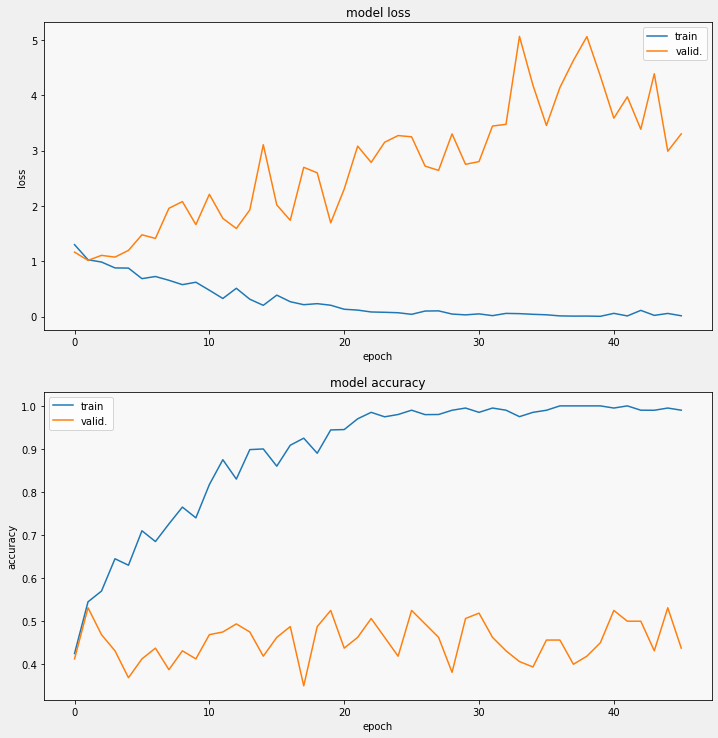

In [16]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 212)